## Spec2Pipeline for MRS   (MIRI MRS CALSPEC2)

`Spec2Pipeline` applies additional instrumental corrections and calibrations to count rate products that result in a fully calibrated individual exposure.

Official documentation for `Spec2Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html>

The `Spec2Pipeline` for MRS comprises a linear series of steps. The steps in order are:

|Step|Description|
|:---|:---|
|`assign_wcs`|attach WCS object to each science exposure|
|`background`|subtract dedicated background exposures|
|`flat_field`|correct the exposure using the flat-field reference file|
|`srctype`|if APT source type set to 'UNKNOWN', sets the 'SRCTYPE' keyword to 'EXTENDED' for MRS|
|`straylight`|remove straylight for Channels 1/2 by interpolating across the inter-slice regions|
|`fringe`|divide the data/error arrays by a fringe reference image|
|`photom`|apply flux (photometric) calibration|
|`cube_build`|produce 3D spectral cubes from the 2D detector image|
|`extract_1d`|extract 1D spectrum from 3D cube|


For more information and examples of each of the steps click on the links in the side bar. 

Note that `cube_build` and `extract_1d` are not calibration steps but are contained in `Spec2Pipeline` to provide users with cubes and 1D spectra from each exposure. Most users of these notebooks may not want to run these steps as they are only interested in the calibrated detector images and the `cube_build` step in particular will dramatically processing time. Therefore, these steps will be skipped.

In this example, no background exposure will be provided so the `background` step will not be run.


### Input data

An example of running the file through the `Spec2Pipeline` is now shown using a simple simulated fullband, 2-point dither observation of a point source (blackbody plus emission lines spectrum) with the MIRI MRS produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1) and brought to level 2A using the `Detector1Pipeline`. 

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

`Spec2Pipeline` can be run by passing indivual exposures or datamodels but in this sample case we produce an association file so all can be run through `Spec2Pipeline` in a single call. It is assumed that the science files are in 'MRS/SHORT', 'MRS/MEDIUM', and 'MRS/LONG'. The content of the association file is printed for inspection.

In [4]:
# load the science and background files to lists
my_science_files = glob.glob('MRS/*/*rate.fits')
my_science_files = sorted(my_science_files)

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, rule=DMSLevel2bBase)
asn.data['products'] = None

# set the association name
asn_name = 'my_point_source'

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'spec2'

for n, sci in enumerate(my_science_files):
    asn.new_product('{}_exposure{}'.format(asn_name, str(n+1)))
    sci_member = Member({'expname': sci, 'exptype': 'science'})    
    new_members = asn.current_product['members']
    new_members.append(sci_member)
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl2_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "spec2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "products": [
        {
            "name": "my_point_source_exposure1",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure2",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure3",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits",
                    "exp

Import Spec2Pipeline and print the docstring to show some information

In [5]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. The cubes and 1D spectra will also be saved.

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output

`steps` : dict, optional, default None  
&nbsp;&nbsp;&nbsp;&nbsp; pass parameters to steps

The `skip` parameters is passed to `cube_build` and `extract_1d` and we explictly save the `photom` output using the `save_results` parameter.
    
The output filenames will be determined by the `asn_name` in the association file which was set in the cell above.

Note that the following cell will result in an error at the very end of execution:

```
RuntimeError: One or more products failed to process. Failing calibration.
```

This results from skipping the `cube_build` and `extract_1d` steps and can be ignored.

In [7]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Spec2Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir, 
                   steps={'photom': {'save_results': True}, 
                          'cube_build': {'skip': True}, 'extract_1d': {'skip': True}})


2019-08-15 15:43:09,963 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-08-15 15:43:09,966 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-08-15 15:43:09,967 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-08-15 15:43:09,969 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-08-15 15:43:09,970 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-08-15 15:43:09,972 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2019-08-15 15:43:09,973 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-08-15 15:43:09,975 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-08-15 15:43:09,976 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2019-08-15 15:43:09,978 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-08-15 15:43:0

2019-08-15 15:43:16,245 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-08-15 15:43:16,247 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-08-15 15:43:16,522 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001608862 -0.001381824 0.001201697 -0.001381824 0.001201697 0.000891269 -0.001608862 0.000891269
2019-08-15 15:43:16,522 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-08-15 15:43:16,530 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-08-15 15:43:16,684 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_im

2019-08-15 15:43:27,794 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-08-15 15:43:27,796 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-08-15 15:43:28,159 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001013317 -0.000940050 0.000379965 -0.000940050 0.000379965 0.000485043 -0.001013317 0.000485043
2019-08-15 15:43:28,160 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-08-15 15:43:28,176 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-08-15 15:43:28,417 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_im

2019-08-15 15:43:43,279 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-08-15 15:43:43,281 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-08-15 15:43:43,609 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.001007126 -0.001198856 0.001803434 -0.001198856 0.001803434 0.001074238 -0.001007126 0.001074238
2019-08-15 15:43:43,610 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-08-15 15:43:43,621 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-08-15 15:43:43,778 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_im

2019-08-15 15:43:55,057 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-08-15 15:43:55,059 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:445: RuntimeWarning: invalid value encountered in greater_equal
  temp >= val_range[1]),

2019-08-15 15:43:55,381 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  -0.000411581 -0.000757081 0.000981701 -0.000757081 0.000981701 0.000668011 -0.000411581 0.000668011
2019-08-15 15:43:55,382 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-08-15 15:43:55,391 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-08-15 15:43:55,573 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<IFUImageModel(1024, 1032) from det_im

2019-08-15 15:45:47,164 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0023.asdf', 'regions': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0024.asdf', 'wavelengthrange': '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2019-08-15 15:45:47,895 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/gwcs/selector.py:444: RuntimeWarning: invalid value encountered in less_equal
  temp = np.where(np.logical_or(temp <= val_range[0],

2019-08-15 15:45:47,897 - stpipe

2019-08-15 15:47:39,338 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0020.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:47:40,986 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0004.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:47:43,184 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/User

2019-08-15 15:48:39,895 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0023.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:48:39,905 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0024.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:48:41,048 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: User

2019-08-15 15:48:50,593 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0021.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:48:50,604 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0020.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:48:52,102 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: User

2019-08-15 15:49:12,584 - CRDS - INFO -  Fetching  /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0020.asdf   31.4 K bytes  (1 / 1 files) (0 / 31.4 K bytes)
2019-08-15 15:49:14,223 - CRDS - INFO -  Fetching  /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0023.asdf   38.0 M bytes  (1 / 1 files) (0 / 38.0 M bytes)
2019-08-15 15:50:27,722 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0034.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:50:28,202 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/

2019-08-15 15:52:21,165 - stpipe.Spec2Pipeline - INFO - Working on input MRS/SHORT/det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits ...
2019-08-15 15:52:21,489 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-08-15 15:52:23,571 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0031.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:52:24,218 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0024.a

2019-08-15 15:52:38,947 - stpipe.Spec2Pipeline - INFO - Working on input MRS/SHORT/det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits ...
2019-08-15 15:52:39,343 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits>,).
2019-08-15 15:52:40,911 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0034.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:52:41,387 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0020.asd

2019-08-15 15:52:50,063 - stpipe.Spec2Pipeline - INFO - Working on input MRS/SHORT/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits ...
2019-08-15 15:52:50,403 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-08-15 15:52:52,505 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0031.asdf' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.4.0.dev1739, but older version asdf-2.4.0.dev58+g96f5e34 is installed
  warnings.warn(fmt_msg)

2019-08-15 15:52:53,152 - stpipe.Spec2Pipeline.assign_wcs - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/asdf/asdf.py:202: UserWarning: File 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0024.a

RuntimeError: One or more products failed to process. Failing calibration.

We can plot the before (rate) and after (cal) images for the first dither position of the SHORT band

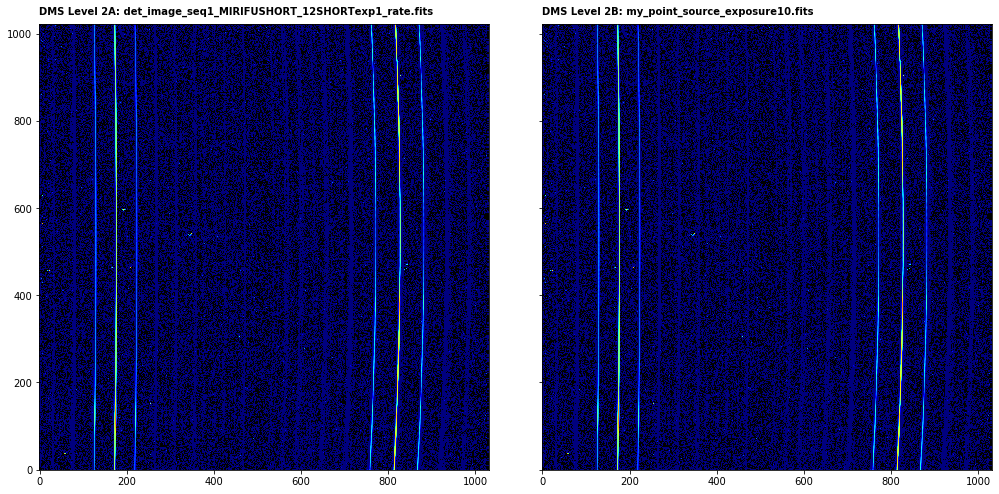

In [25]:
# use the association to identify the linked files
cal_file = asn['products'][9]['name'] + '.fits'
rate_file = asn['products'][9]['members'][0]['expname']

# open the input level 2A image and calibrated 2B image a jwst data models
with datamodels.open(rate_file) as in_dm:
    with datamodels.open(rate_file) as out_dm:

        fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

        axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1, vmax=100))
        axs[0].annotate('DMS Level 2A: {}'.format(os.path.basename(rate_file)), xy=(0.0, 1.02), xycoords='axes fraction', 
                        fontsize=10, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1, vmax=100))
        axs[1].annotate('DMS Level 2B: {}'.format(cal_file), xy=(0.0, 1.02), xycoords='axes fraction', 
                        fontsize=10, fontweight='bold', color='k')
        axs[1].set_facecolor('black')
        plt.tight_layout()
        plt.show()


### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_point_source_lvl2_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "spec2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "products": [
        {
            "name": "my_point_source_exposure1",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure2",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq1_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure3",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq2_MIRIFULONG_34LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure4",
            "members": [
                {
                    "expname": "MRS/LONG/det_image_seq2_MIRIFUSHORT_12LONGexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure5",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure6",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq1_MIRIFUSHORT_12MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure7",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq2_MIRIFULONG_34MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure8",
            "members": [
                {
                    "expname": "MRS/MEDIUM/det_image_seq2_MIRIFUSHORT_12MEDIUMexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure9",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure10",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure11",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq2_MIRIFULONG_34SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "my_point_source_exposure12",
            "members": [
                {
                    "expname": "MRS/SHORT/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits",
                    "exptype": "science"
                }
            ]
        }
    ],
    "asn_pool": "my_point_source_pool"
}
```

**Option 1:**
Run the `Spec2Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Spec2Pipeline my_point_source_lvl2_asn.json --output_dir demo_output --steps.photom.save_results True --steps.cube_build.skip True --steps.extract_1d.skip True
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Spec2Pipeline` using the `strun` command with the associated `calwebb_spec2.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_spec2.cfg my_point_source_lvl2_asn.json --output_dir demo_output --steps.photom.save_results True --steps.cube_build.skip True --steps.extract_1d.skip True
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*